In [1]:
from IPython.display import Image

In [2]:
from sklearn import datasets
import numpy as np


In [3]:
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target


In [4]:
print('Class labels:', np.unique(y))

Class labels: [0 1 2]


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)



In [6]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))


Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


In [7]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


In [8]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(n_iter=40, eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)


Perceptron(alpha=0.0001, class_weight=None, eta0=0.1, fit_intercept=True,
      n_iter=40, n_jobs=1, penalty=None, random_state=1, shuffle=True,
      verbose=0, warm_start=False)

In [9]:
y_pred = ppn.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())


Misclassified samples: 3


In [10]:
from sklearn.metrics import accuracy_score

print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))


Accuracy: 0.93


In [11]:
print('Accuracy: %.2f' % ppn.score(X_test_std, y_test))

Accuracy: 0.93


In [12]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt



In [13]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

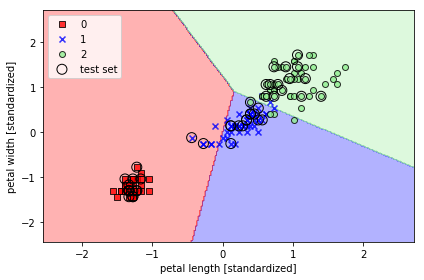

In [14]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/03_01.png', dpi=300)
plt.show()


In [15]:
# ### Logistic regression intuition and conditional probabilities

In [16]:
import matplotlib.pyplot as plt
import numpy as np



In [17]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))


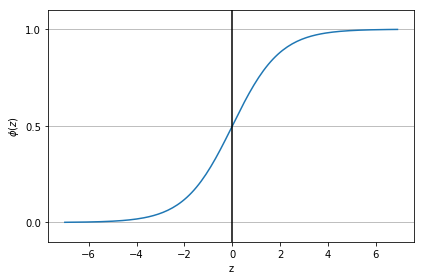

In [18]:
z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)

plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')

# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
#plt.savefig('images/03_02.png', dpi=300)
plt.show()


In [19]:
def cost_1(z):
    return - np.log(sigmoid(z))


def cost_0(z):
    return - np.log(1 - sigmoid(z))



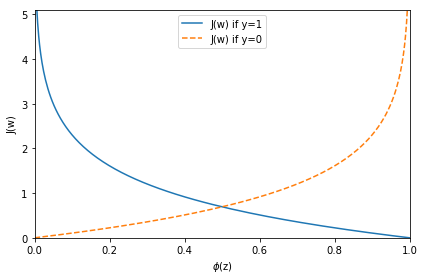

In [20]:
z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)

c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')

c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')

plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
#plt.savefig('images/03_04.png', dpi=300)
plt.show()



In [21]:
class LogisticRegressionGD(object):
    """Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Sum-of-squares cost function value in each epoch.

    """
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            # note that we compute the logistic `cost` now
            # instead of the sum of squared errors cost
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        # equivalent to:
        # return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)


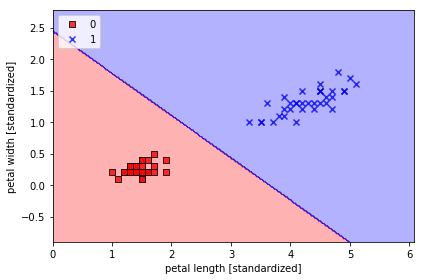

In [22]:
X_train_01_subset = X_train[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset,
         y_train_01_subset)

plot_decision_regions(X=X_train_01_subset, 
                      y=y_train_01_subset,
                      classifier=lrgd)

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/03_05.png', dpi=300)
plt.show()



In [23]:
### Training a logistic regression model with scikit-learn

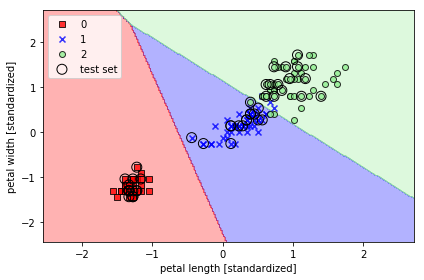

In [24]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=100.0, random_state=1)
lr.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_06.png', dpi=300)
plt.show()



In [25]:
lr.predict_proba(X_test_std[:3, :])

array([[  3.20136878e-08,   1.46953648e-01,   8.53046320e-01],
       [  8.34428069e-01,   1.65571931e-01,   4.57896429e-12],
       [  8.49182775e-01,   1.50817225e-01,   4.65678779e-13]])

In [26]:
lr.predict_proba(X_test_std[:3, :]).sum(axis=1)


array([ 1.,  1.,  1.])

In [27]:
lr.predict_proba(X_test_std[:3, :]).argmax(axis=1)


array([2, 0, 0], dtype=int64)

In [28]:
lr.predict(X_test_std[:3, :])

array([2, 0, 0])

In [29]:
lr.predict(X_test_std[0, :].reshape(1, -1))


array([2])

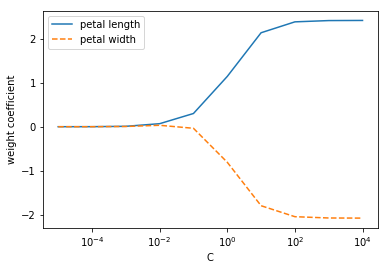

In [30]:
# ### Tackling overfitting via regularization

weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c, random_state=1)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)

weights = np.array(weights)
plt.plot(params, weights[:, 0],
         label='petal length')
plt.plot(params, weights[:, 1], linestyle='--',
         label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
#plt.savefig('images/03_08.png', dpi=300)
plt.show()



In [31]:
# # Maximum margin classification with support vector machines



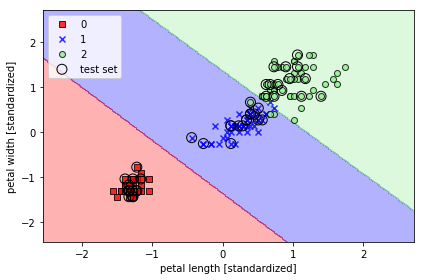

In [32]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, 
                      y_combined,
                      classifier=svm, 
                      test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_11.png', dpi=300)
plt.show()


In [35]:
# ## Alternative implementations in scikit-learn

from sklearn.linear_model import SGDClassifier

ppn = SGDClassifier(loss='perceptron', n_iter=1000)
lr = SGDClassifier(loss='log', n_iter=1000)
svm = SGDClassifier(loss='hinge', n_iter=1000)


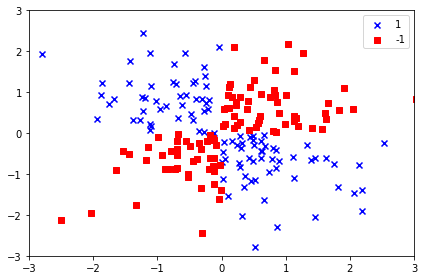

In [36]:
# # Solving non-linear problems using a kernel SVM

import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)

plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='b', marker='x',
            label='1')
plt.scatter(X_xor[y_xor == -1, 0],
            X_xor[y_xor == -1, 1],
            c='r',
            marker='s',
            label='-1')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
#plt.savefig('images/03_12.png', dpi=300)
plt.show()


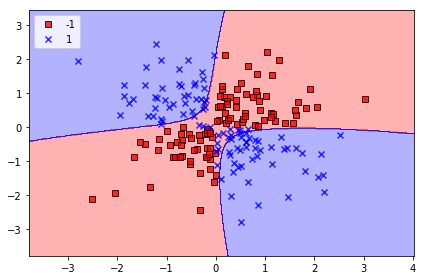

In [37]:
# ## Using the kernel trick to find separating hyperplanes in higher dimensional space

svm = SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor,
                      classifier=svm)

plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_14.png', dpi=300)
plt.show()


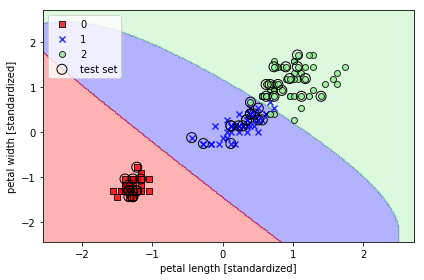

In [38]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_15.png', dpi=300)
plt.show()


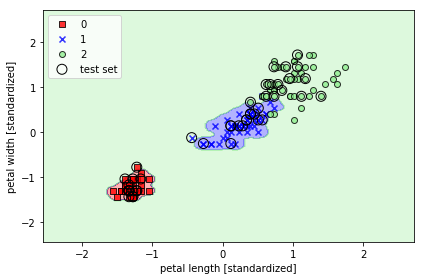

In [39]:
svm = SVC(kernel='rbf', random_state=1, gamma=100.0, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_16.png', dpi=300)
plt.show()


In [40]:
# # Decision tree learning

In [41]:
import matplotlib.pyplot as plt
import numpy as np


In [42]:
def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1 - p))


def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))


def error(p):
    return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)

ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e * 0.5 if e else None for e in ent]
err = [error(i) for i in x]



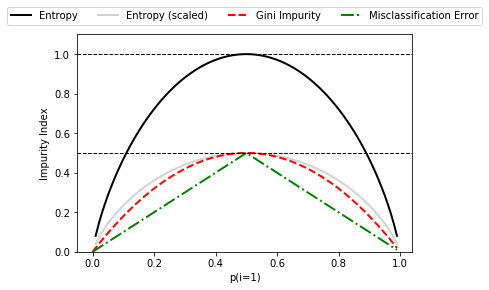

In [43]:
fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err], 
                          ['Entropy', 'Entropy (scaled)', 
                           'Gini Impurity', 'Misclassification Error'],
                          ['-', '-', '--', '-.'],
                          ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=5, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
#plt.savefig('images/03_19.png', dpi=300, bbox_inches='tight')
plt.show()



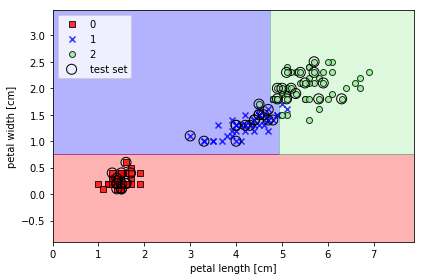

In [44]:
# ## Building a decision tree

from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=4, 
                              random_state=1)
tree.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_20.png', dpi=300)
plt.show()



In [45]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree,
                           filled=True, 
                           rounded=True,
                           class_names=['Setosa', 
                                        'Versicolor',
                                        'Virginica'],
                           feature_names=['petal length', 
                                          'petal width'],
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('tree.png') 


ModuleNotFoundError: No module named 'pydotplus'

In [46]:
# ## Combining weak to strong learners via random forests

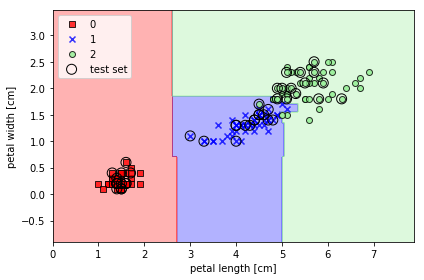

In [47]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='gini',
                                n_estimators=25, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

plot_decision_regions(X_combined, y_combined, 
                      classifier=forest, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_22.png', dpi=300)
plt.show()



In [48]:
# # K-nearest neighbors - a lazy learning algorithm

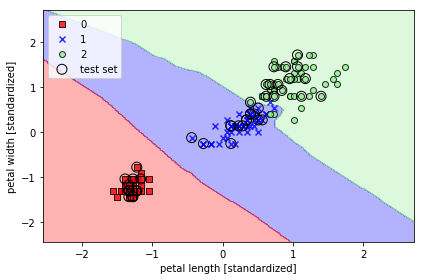

In [49]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, 
                           p=2, 
                           metric='minkowski')
knn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=knn, test_idx=range(105, 150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_24.png', dpi=300)
plt.show()
